<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/Kaggle/Global_Wheat_Detection/Global_Wheat_Detection_Baseline(CenterNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd ./drive/My\ Drive/Deep_learning/Kaggle/Global_Wheat_Detection/

/content/drive/My Drive/Deep_learning/Kaggle/Global_Wheat_Detection


In [0]:
# !unzip global-wheat-detection.zip

In [4]:
!ls

 centernet.hdf5					     sample_submission.csv
'Global_Wheat_Detection_Baseline(CenterNet).ipynb'   submission.csv
 global-wheat-detection.zip			     test
 hourglass1-2.h5				     train
 hourglass1-3.h5				     train.csv
 hourglass1.h5					     Tutorial.ipynb


# Keras CenterNet Baseline Training

This is simple baseline kernal for training CenterNet with Hourglass backbone for Global Wheat Detection.

Thanks to [@see--](https://www.kaggle.com/seesee) for their CenterNet Keras port repo: https://github.com/see--/keras-centernet

Thanks to [@pestipeti](https://www.kaggle.com/pestipeti) for their competition metric kernal and visualization script: https://www.kaggle.com/pestipeti/competition-metric-details-script

Thanks to [@diegojohnson](https://www.kaggle.com/diegojohnson) for their heatmap script: https://www.kaggle.com/diegojohnson/centernet-objects-as-points

# Imports and Load data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics

import keras
from keras.callbacks import Callback, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

class config:
    epochs = 10
    batch_size = 1
    num_classes = 3
    IMAGE_PATH = './train/'
    lr = 1e-4
    seed = 42

import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(config.seed)

Using TensorFlow backend.


In [6]:
df = pd.read_csv('./train.csv')
train_df = os.listdir(config.IMAGE_PATH)
print(len(train_df))
train_df, val_df = train_test_split(train_df, random_state=config.seed, test_size=0.2)
print(len(train_df), len(val_df))

# Remove empty images from training
bad_imgs = []
for id in train_df:
  if len(df[df['image_id']==id[:-4]]) == 0:
    bad_imgs.append(id)

for im in bad_imgs:
  train_df.remove(im)
print(len(train_df), len(val_df))

3422
2737 685
2700 685


# Utils

In [0]:
def normalize_image(image):
  """Normalize the image for the Hourglass network.
  # Arguments
    image: BGR uint8
  # Returns
    float32 image with the same shape as the input
  """
  mean = [0.40789655, 0.44719303, 0.47026116]
  std = [0.2886383, 0.27408165, 0.27809834]
  return ((np.float32(image) / 255.) - mean) / std

from math import floor

def get_boxes(bbox):
  boxes = []
  for box in bbox:
    box = box[1:-1].split(',')
    box = [float(b) for b in box]
    box = [int(b) for b in box]
    boxes.append(box)

  boxes = np.array(boxes, dtype=np.int32)
  return boxes

def heatmap(bbox):
    def get_coords(bbox):
      xs,ys,w,h=[],[],[],[]
      for box in bbox:
        box = box[1:-1].split(',')
        box = [float(b) for b in box]
        box = [int(b) for b in box]

        x1, y1, width, height = box
        xs.append(x1+int(width/2))
        ys.append(y1+int(height/2))
        w.append(width)
        h.append(height)
      
      return xs, ys, w, h
    
    def get_heatmap(p_x, p_y):
        # Ref: https://www.kaggle.com/diegojohnson/centernet-objects-as-points
        X1 = np.linspace(1, 1024, 1024)
        Y1 = np.linspace(1, 1024, 1024)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        sigma_ = 10
        E2 = 2.0 * sigma_ ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap

    coors = []
    size = 20
    y_ = size
    while y_ > -size - 1:
      x_ = -size
      while x_ < size + 1:
        coors.append([x_, y_])
        x_ += 1
      y_ -= 1

    u, v, w, h = get_coords(bbox)
    
    if len(bbox) == 0:
      u = np.array([512])
      v = np.array([512])
      w = np.array([10])
      h = np.array([10])
    
    hm = np.zeros((1024,1024,1))
    width = np.zeros((1024,1024,1))
    height = np.zeros((1024,1024,1))
    for i in range(len(u)):
      for coor in coors:
        try:
          width[int(v[i])+coor[0], int(u[i])+coor[1]] = w[i] / 256
          height[int(v[i])+coor[0], int(u[i])+coor[1]] = h[i] / 256
        except:
          pass
      heatmap = get_heatmap(u[i], v[i])
      hm[:,:] = np.maximum(hm[:,:],heatmap[:,:])
      
    hm = cv2.resize(hm, (256,256))[:,:,None]
    width = cv2.resize(width, (256,256))[:,:,None]
    height = cv2.resize(height, (256,256))[:,:,None]
    return hm, width, height

# Dataset

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=config.IMAGE_PATH, image_paths=None,
                 batch_size=4, dim=(128, 128), n_channels=3,
                 n_classes=3, random_state=config.seed, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.image_paths = image_paths
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        X = []
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.image_paths[ID]
            img_path = f"{self.base_path}{im_name}"
            img = self.__load_rgb(img_path)
            
            X.append(img)

        X = np.array(X)
        return X
    
    def __generate_y(self, list_IDs_batch):
        y1 = []
        y2 = []
        for i, ID in enumerate(list_IDs_batch):
            image_id = self.image_paths[ID][:-4]
            bbox = self.df[self.df['image_id']==image_id]['bbox']
            mask, width, height = heatmap(bbox)
            y1.append(np.concatenate([mask,width,height], axis=-1))
            y2.append(mask)
        
        y1 = np.array(y1)
        y2 = np.array(y2)
        return [y1,y2]
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        img = normalize_image(img)
        return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


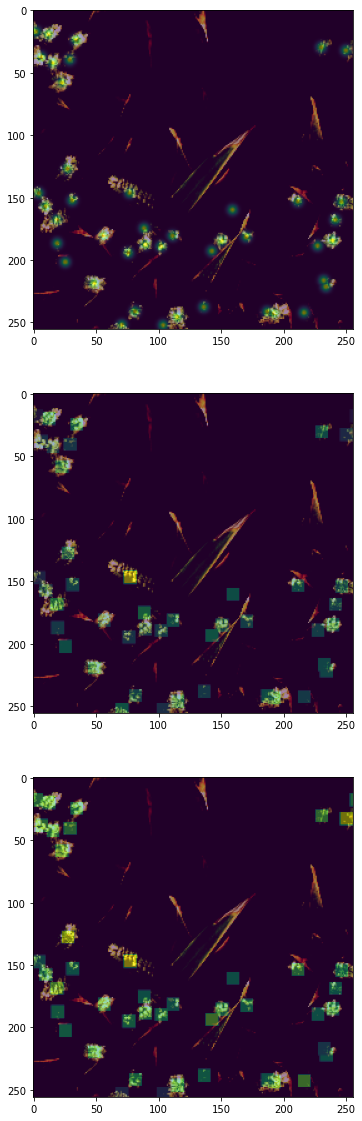

In [9]:
train_gen = DataGenerator(
    list(range(len(train_df))), 
    df=df,
    target_df=df,
    batch_size=config.batch_size,
    dim=(1024,1024),
    n_classes=config.num_classes,
    image_paths=train_df,
    shuffle=True
)

img, regr = train_gen.__getitem__(1)
hm = regr[1][0][:,:,0]
width = regr[0][0][:,:,1]
height = regr[0][0][:,:,2]

img = cv2.resize(img[0], (256,256))

nrow, ncol = 3, 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
  if i == 0:
    ax.imshow(img)
    ax.imshow(hm, alpha=0.5)
  elif i == 1:
    ax.imshow(img)
    ax.imshow(width, alpha=0.5)
  else:
    ax.imshow(img)
    ax.imshow(height, alpha=0.5)

# Centernet Model

In [10]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense, Activation, Input, Conv2D, BatchNormalization, Add, UpSampling2D, ZeroPadding2D, Lambda, Concatenate, Dropout, SpatialDropout2D
from keras.models import Sequential, Model
from keras.utils import get_file

weights_path = './hourglass1-3.h5'
# './centernet.hdf5'
# weights_path = get_file('centernet.hdf5',
#                           'https://github.com/see--/keras-centernet/releases/download/0.1.0/ctdet_coco_hg.hdf5',
#                           cache_subdir='/kaggle/working/', 
#                           file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')

def HourglassNetwork(heads, num_stacks, cnv_dim=256, inres=(512, 512), weights_path=weights_path,
                     dims=[256, 384, 384, 384, 512]):
    """Instantiates the Hourglass architecture.
    Optionally loads weights pre-trained on COCO.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
      num_stacks: number of hourglass modules.
      cnv_dim: number of filters after the resolution is decreased.
      inres: network input shape, should be a multiple of 128.
      weights: one of `None` (random initialization),
            'ctdet_coco' (pre-training on COCO for 2D object detection),
            'hpdet_coco' (pre-training on COCO for human pose detection),
            or the path to the weights file to be loaded.
      dims: numbers of channels in the hourglass blocks.
    # Returns
      A Keras model instance.
    # Raises
      ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
    """
    
    input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
    inter = pre(input_layer, cnv_dim)
    prev_inter = None
    outputs = []
    for i in range(num_stacks):
        prev_inter = inter
        _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims)
        if i == 1:
            if _heads is not None:
                outputs.extend(_heads)
        if i < num_stacks - 1:
            inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
            inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.1' % i)(inter_)

            cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
            cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.1' % i)(cnv_)

            inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
            inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
            inter = residual(inter, cnv_dim, 'inters.%d' % i)

    model = Model(inputs=input_layer, outputs=outputs)

    # load weights
    print('Loading weights...')
    model.load_weights(weights_path, by_name=True)
    print('Done!')

    return model

def hourglass_module(heads, bottom, cnv_dim, hgid, dims):
    # create left features , f1, f2, f4, f8, f16 and f32
    lfs = left_features(bottom, hgid, dims)

    # create right features, connect with left features
    rf1 = right_features(lfs, hgid, dims)
    rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)

    # add 1x1 conv with two heads, inter is sent to next stage
    # head_parts is used for intermediate supervision
    if heads is not None:
        heads = create_heads(heads, rf1, hgid)
    return heads, rf1

def convolution(_x, k, out_dim, name, stride=1):
    padding = (k - 1) // 2
    _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
    _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

def residual(_x, out_dim, name, stride=1):
    shortcut = _x
    num_channels = K.int_shape(shortcut)[-1]
    _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
    _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
    _x = Activation('relu', name=name + '.relu1')(_x)

    _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)

    if num_channels != out_dim or stride != 1:
        shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
            shortcut)
        shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.1')(shortcut)

    _x = Add(name=name + '.add')([_x, shortcut])
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

def pre(_x, num_channels):
    # front module, input to 1/4 resolution
    _x = convolution(_x, 7, 128, name='pre.0', stride=2)
    _x = residual(_x, num_channels, name='pre.1', stride=2)
    return _x

def left_features(bottom, hgid, dims):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8, f16, f32 : 1, 1/2, 1/4 1/8, 1/16, 1/32 resolution
    # 5 times reduce/increase: (256, 384, 384, 384, 512)
    features = [bottom]
    for kk, nh in enumerate(dims):
        pow_str = ''
        for _ in range(kk):
            pow_str += '.center'
        _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=2)
        _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
        features.append(_x)
    return features

def connect_left_right(left, right, num_channels, num_channels_next, name):
    # left: 2 residual modules
    left = residual(left, num_channels_next, name=name + 'skip.0')
    left = residual(left, num_channels_next, name=name + 'skip.1')

    # up: 2 times residual & nearest neighbour
    out = residual(right, num_channels, name=name + 'out.0')
    out = residual(out, num_channels_next, name=name + 'out.1')
    out = UpSampling2D(name=name + 'out.upsampleNN')(out)
    out = Add(name=name + 'out.add')([left, out])
    return out

def bottleneck_layer(_x, num_channels, hgid):
    # 4 residual blocks with 512 channels in the middle
    pow_str = 'center.' * 5
    _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
    return _x

def right_features(leftfeatures, hgid, dims):
    rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
    for kk in reversed(range(len(dims))):
        pow_str = ''
        for _ in range(kk):
            pow_str += 'center.'
        rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
    return rf

def create_heads(heads, rf1, hgid):
    _heads = []
    for head in heads:
        num_channels = heads[head]
        _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
        _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
        _x = Conv2D(num_channels, 1, use_bias=True, name=head + '.%d.1' % hgid)(_x)
        _heads.append(_x)
    return _heads

kwargs = {
        'num_stacks': 2,
        'cnv_dim': 256,
        'inres': (1024, 1024),
        }
heads = {
        'regr': 2,
        'confidence': 1
        }
model = HourglassNetwork(heads=heads, **kwargs)

Loading weights...
Done!


# Compile Model

In [0]:
# Ref: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
alpha = .25
gamma = 2
def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
  weight_a = alpha * (1 - y_pred) ** gamma * targets
  weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
  return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

def focal_loss(y_true, y_pred):
  y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
  logits = tf.math.log(y_pred / (1 - y_pred))

  loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

  # or reduce_sum and/or axis=-1
  return tf.reduce_mean(loss)

from keras.losses import mean_squared_error

def criterion(y_true, y_pred): # Regression Loss
    mask = y_true[:,:,:, 0][:,:,:,np.newaxis]
    regr = y_true[:,:,:, 1:]

    regr_loss = mean_squared_error(regr, y_pred)
    loss = regr_loss

    return loss

def criterion2(y_true, y_pred): # Heatmap Loss
    mask = y_true[:,:,:, 0][:,:,:,np.newaxis]
    prediction = y_pred

    # Binary mask loss
    pred_mask = tf.sigmoid(prediction[:,:,:, 0])[:,:,:,np.newaxis]
    mask_loss = focal_loss(mask, pred_mask)
    mask_loss = tf.reduce_mean(mask_loss)

    loss = mask_loss
    return loss

from keras.optimizers import Adam
opt = Adam(lr=config.lr)
model.compile(optimizer=opt, loss=[criterion, criterion2], loss_weights=[5, 1])

# Decoder

In [0]:
def _nms(heat, kernel=3):
  hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
  keep = K.cast(K.equal(hmax, heat), K.floatx())
  return heat * keep

def decode_ddd(regr_, hm_, k, output_stride):
  hm = K.sigmoid(K.expand_dims(hm_[:,:,:,0]))
  regr = regr_
  hm = _nms(hm)
  hm_shape = K.shape(hm)
  regr_shape = K.shape(regr)
  batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

  hm_flat = K.reshape(hm, (batch, -1))
  regr_flat = K.reshape(regr, (regr_shape[0], -1, regr_shape[-1]))

  def _process_sample(args):
    _hm, _regr = args
    _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
    _classes = K.cast(_inds % cat, 'float32')
    _inds = K.cast(_inds / cat, 'int32')
    _xs = K.cast(_inds % width, 'float32')
    _ys = K.cast(K.cast(_inds / width, 'int32'), 'float32')
    _xs *= output_stride
    _ys *= output_stride

    _regr = K.gather(_regr, _inds)

    _width = _regr[:,0] * 256
    _height = _regr[:,1] * 256

    _detection = K.stack([_xs, _ys, _scores, _classes, _width, _height], -1)
    return _detection

  detections = K.map_fn(_process_sample, [hm_flat, regr_flat], dtype=K.floatx())
  return detections

def add_decoder(model, k=125, output_stride=4):
  def _decode(args):
    _regr, _hm = args
    return decode_ddd(_regr, _hm, k=k, output_stride=output_stride)

  output = Lambda(_decode)([*model.outputs])
  model = Model(model.input, output)
  return model

# IOU/Precision Utils

In [0]:
# Ref: https://www.kaggle.com/pestipeti/competition-metric-details-script

from collections import namedtuple
from typing import List, Union

Box = namedtuple('Box', 'xmin ymin xmax ymax')

def calculate_iou(gt: List[Union[int, float]],
                  pred: List[Union[int, float]],
                  form: str = 'pascal_voc') -> float:
    """Calculates the IoU.
    
    Args:
        gt: List[Union[int, float]] coordinates of the ground-truth box
        pred: List[Union[int, float]] coordinates of the prdected box
        form: str gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        IoU: float Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        bgt = Box(gt[0], gt[1], gt[0] + gt[2], gt[1] + gt[3])
        bpr = Box(pred[0], pred[1], pred[0] + pred[2], pred[1] + pred[3])
    else:
        bgt = Box(gt[0], gt[1], gt[2], gt[3])
        bpr = Box(pred[0], pred[1], pred[2], pred[3])
        

    overlap_area = 0.0
    union_area = 0.0

    # Calculate overlap area
    dx = min(bgt.xmax, bpr.xmax) - max(bgt.xmin, bpr.xmin)
    dy = min(bgt.ymax, bpr.ymax) - max(bgt.ymin, bpr.ymin)

    if (dx > 0) and (dy > 0):
        overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (bgt.xmax - bgt.xmin) * (bgt.ymax - bgt.ymin) +
            (bpr.xmax - bpr.xmin) * (bpr.ymax - bpr.ymin) -
            overlap_area
    )

    return overlap_area / union_area

def find_best_match(gts, predd, threshold=0.5, form='pascal_voc'):
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).
    
    Args:
        gts: Coordinates of the available ground-truth boxes
        pred: Coordinates of the predicted box
        threshold: Threshold
        form: Format of the coordinates
        
    Return:
        Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    
    for gt_idx, ggt in enumerate(gts):
        iou = calculate_iou(ggt, predd, form=form)
        
        if iou < threshold:
            continue
        
        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(preds_sorted, gt_boxes, threshold=0.5, form='coco'):
    """Calculates precision per at one threshold.
    
    Args:
        preds_sorted: 
    """
    tp = 0
    fp = 0
    fn = 0

    fn_boxes = []

    for pred_idx, pred in enumerate(preds_sorted):
        best_match_gt_idx = find_best_match(gt_boxes, pred, threshold=threshold, form='coco')

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1

            # Remove the matched GT box
            gt_boxes = np.delete(gt_boxes, best_match_gt_idx, axis=0)

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fn += 1
            fn_boxes.append(pred)

    # False negative: indicates a gt box had no associated predicted box.
    fp = len(gt_boxes)
    precision = tp / (tp + fp + fn)
    return precision, fn_boxes, gt_boxes

def calculate_image_precision(preds_sorted, gt_boxes, thresholds=(0.5), form='coco', debug=False):
    
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    for threshold in thresholds:
        precision_at_threshold, _, _ = calculate_precision(preds_sorted,
                                                           gt_boxes,
                                                           threshold=threshold,
                                                           form=form
                                                          )
        if debug:
            print("@{0:.2f} = {1:.4f}".format(threshold, precision_at_threshold))

        image_precision += precision_at_threshold / n_threshold
    
    return image_precision

# MAP

In [0]:
def calcmAP(model, threshold=0.5):
  model_ = add_decoder(model)
  
  iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
  
  precision = []

  for idx in trange(len(val_df)):
    image_path = val_df[idx]
    img = cv2.cvtColor(cv2.imread(f'{config.IMAGE_PATH}{image_path}'), cv2.COLOR_BGR2RGB)
    img = normalize_image(img)
    
    image_id = image_path[:-4]
    bbox = df[df['image_id']==image_id]['bbox']
    boxes = get_boxes(bbox)

    out = model_.predict(img[None])

    pred_box,scores=[],[]

    for detection in out[0]:
      if detection[2] > threshold:
        x, y, score, _, width, height = detection
        pred_box.append([max(x-(width/2.), 0), max(y-(height/2.), 0), width, height])
        scores.append(score)

    pred_box = np.array(pred_box, dtype=np.int32)
    scores = np.array(scores)

    preds_sorted_idx = np.argsort(scores)[::-1]
    preds_sorted = pred_box[preds_sorted_idx]

    if len(boxes) > 0:
      image_precision = calculate_image_precision(preds_sorted, boxes,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
      precision.append(image_precision)
    else:
      if len(preds_sorted) > 0:
        precision.append(0)
  
  precision = np.array(precision)
  return np.mean(precision)

In [0]:
class SaveBestmAP(tf.keras.callbacks.Callback):
  def __init__(self, path):
    super(SaveBestmAP, self).__init__()
    self.best_weights = None
    self.path = path

  def on_train_begin(self, logs=None):
    self.best = 0

  def on_epoch_end(self, epoch, logs=None):
    current = calcmAP(self.model, 0.4)
    if np.greater(current, self.best):
      self.best = current
      self.best_weights = self.model.get_weights()
      print(f'Best mAP: {current}, saving...')
      self.model.save_weights(self.path)
    else:
      print(f'Current mAP: {current}')
  
  def on_train_end(self, logs=None):
    print(f'Loading best model...')
    self.model.load_weights(self.path)

# Training

In [0]:
from keras.callbacks import ReduceLROnPlateau

train_gen = DataGenerator(
    list(range(len(train_df))), 
    df=df,
    target_df=df,
    batch_size=config.batch_size,
    dim=(1024,1024),
    n_classes=config.num_classes,
    image_paths=train_df,
    shuffle=True
)

val_gen = DataGenerator(
    list(range(len(val_df))), 
    df=df,
    target_df=df,
    batch_size=config.batch_size,
    dim=(1024,1024),
    n_classes=config.num_classes,
    image_paths=val_df,
    shuffle=False
)

checkpoint1 = ModelCheckpoint(
    'hourglass1.h5',
    monitor='loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

checkpoint2 = ModelCheckpoint(
    'hourglass1-2.h5',
    monitor='loss', 
    verbose=0, 
    save_best_only=False,
    save_weights_only=True,
    mode='auto'
)

reducelr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.25,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

savemAP = SaveBestmAP('hourglass1-3.h5')

In [0]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    callbacks=[reducelr, checkpoint1, checkpoint2, savemAP],
    use_multiprocessing=False,
    workers=4
)

# Testing

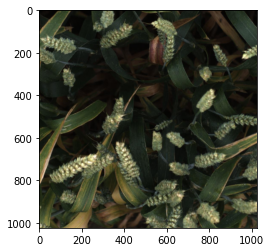

In [0]:
test_img = f'./train/{val_df[0]}'

bbox = df[df['image_id']==val_df[0][:-4]]['bbox']
boxes = get_boxes(bbox)

img = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [0]:
img = normalize_image(img)
regr, hm = model.predict(img[None])

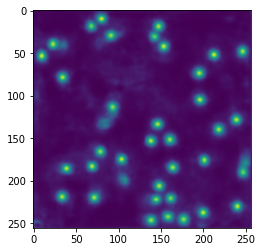

In [0]:
img_ = cv2.resize(img, (256,256))
plt.imshow(tf.sigmoid(hm[0][:,:,0]))

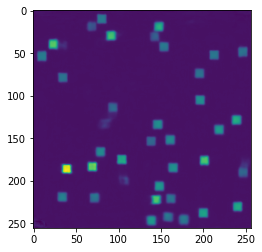

In [0]:
plt.imshow(regr[0][:,:,0])

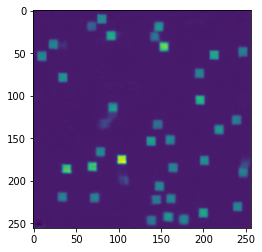

In [0]:
plt.imshow(regr[0][:,:,1])

In [0]:
model_ = add_decoder(model)

In [0]:
img = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)
img = normalize_image(img)
out = model_.predict(img[None]) # bs x 125 x 6

In [0]:
pred_box,scores=[],[]

for detection in out[0]:
  if detection[2] > 0.25:
    x, y, score, _, width, height = detection
    pred_box.append([max(x-(width/2.), 0), max(y-(height/2.), 0), width, height])
    scores.append(score)

pred_box = np.array(pred_box, dtype=np.int32)
scores = np.array(scores)

preds_sorted_idx = np.argsort(scores)[::-1]
preds_sorted = pred_box[preds_sorted_idx]

In [0]:
preds_sorted

array([[808, 151,  79, 112],
       [279,   0,  81,  88],
       [  0, 171,  83,  81],
       [572,  90,  79, 155],
       [896, 879, 126,  80],
       [354, 610, 122, 179],
       [ 51, 672, 208, 135],
       [519, 558,  65, 107],
       [195, 667, 160, 128],
       [736, 891, 119, 112],
       [728, 358, 103, 122],
       [886, 474, 131,  74],
       [535, 781, 112,  85],
       [ 12, 116, 158,  78],
       [726, 658, 155,  90],
       [946, 153,  74,  77],
       [ 98, 264,  75,  94],
       [742, 255,  75,  80],
       [ 90, 835,  90,  80],
       [533, 503, 101,  64],
       [815, 510, 112,  98],
       [520,  25, 135, 100],
       [603, 696, 105,  78],
       [288,  57, 151, 116],
       [495, 948, 112,  70],
       [246, 840,  75,  78],
       [591, 565,  96,  85],
       [497, 852, 156,  70],
       [663, 938,  80,  83],
       [266, 620,  98,  86],
       [591, 917,  80, 101],
       [339, 402,  65,  99],
       [605, 837,  77,  84],
       [951, 721,  65,  77],
       [246,  

In [0]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]),
            (220, 0, 0), 2
        )

    if gt_boxes is not None:
      for gt_box in gt_boxes:    
          cv2.rectangle(
              sample,
              (gt_box[0], gt_box[1]),
              (gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]),
              (0, 0, 220), 2
          )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")

Score: 0.6327456585010012


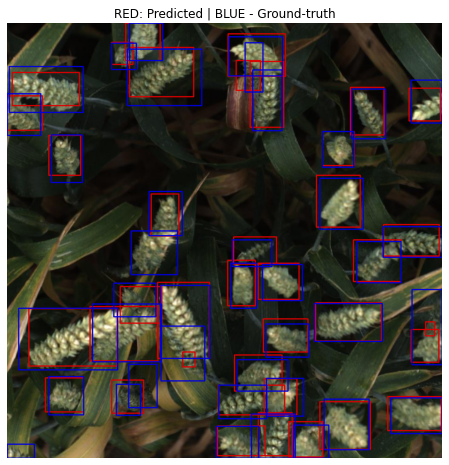

In [0]:
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
image_precision = calculate_image_precision(preds_sorted, boxes,
                                                thresholds=iou_thresholds,
                                                form='coco', debug=False)
print(f'Score: {image_precision}')

show_result(1, preds_sorted, boxes)

## And that is all! If you found this kernal helpful consider upvoting!

## Things to experiment with:

- Train for longer (100+ epochs)
- Add augmentation
- Change loss functions
- Change heatmap and regression maps (change sizes)
- Change backbone (Resnet)
- Change model architecture (features, length)
- Add Offset regression
- Incorporate empty images into training

## If you are interested in learning more about CenterNet I recommend these other great kernals

'CenterNet -Keypoint Detector-' https://www.kaggle.com/kmat2019/centernet-keypoint-detector by [@kmat2019](https://www.kaggle.com/kmat2019) for Kuzushiji Recognition Competition

'CenterNet Baseline' https://www.kaggle.com/hocop1/centernet-baseline by [@hocop1](https://www.kaggle.com/hocop1) for Peking University/Baidu - Autonomous Driving Competition

#### as well as the offical Pytorch implementation and paper:
> https://github.com/xingyizhou/CenterNet

> [**Objects as Points**](http://arxiv.org/abs/1904.07850),            
> Xingyi Zhou, Dequan Wang, Philipp Kr&auml;henb&uuml;hl,        
> *arXiv technical report ([arXiv 1904.07850](http://arxiv.org/abs/1904.07850))*

# Submission

In [18]:
sample = pd.read_csv('./sample_submission.csv')
test_df = sample['image_id']
test_df

0    aac893a91
1    51f1be19e
2    f5a1f0358
3    796707dd7
4    51b3e36ab
5    348a992bb
6    cc3532ff6
7    2fd875eaa
8    cb8d261a3
9    53f253011
Name: image_id, dtype: object

In [0]:
result = dict()
submission = []
for i in range(len(test_df)):
  test_img = f'./test/{test_df[i]}' + '.jpg'
  img = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)
  img = normalize_image(img)
  out = model_.predict(img[None]) # bs x 125 x 6
  
  pred_box,scores=[],[]
  prediction_string = []
  for detection in out[0]:
    if detection[2] > 0.25:
      x, y, score, _, width, height = detection
      x = int(max(x-(width/2.), 0))
      y = int(max(y-(height/2.), 0))
      h = int(height)
      w = int(width)
      s = score
      pred_box.append([max(x-(width/2.), 0), max(y-(height/2.), 0), width, height])
      scores.append(score)
      prediction_string.append(f"{s} {x} {y} {h} {w}")
  prediction_string = " ".join(prediction_string)
  
  pred_box = np.array(pred_box, dtype=np.int32)
  scores = np.array(scores)

  preds_sorted_idx = np.argsort(scores)[::-1]
  preds_sorted = pred_box[preds_sorted_idx]
  
  scores_ = [str(s)[:6] for s in scores]

  submission.append([test_df[i],prediction_string])

  if len(scores) != 0:
    bbox_result = ' '.join(np.concatenate((np.reshape(scores_, [len(scores_), 1]).astype(str), preds_sorted.astype(str)), axis=1).reshape(-1).tolist())
    result[test_df[i]] = bbox_result
  else:
    result[test_df[i]] = ''

In [0]:
sample_submission = pd.DataFrame(submission, columns=["image_id","PredictionString"])
sample_submission.to_csv('submission.csv', index=False)

In [22]:
# submission_df = pd.DataFrame(result.items(), columns=['image_id', 'PredictionString'])
# submission_df.to_csv('submission.csv', index=False)
# submission_df.head()

,image_id,PredictionString
0,aac893a91,0.5534 698 385 114 180 0.5435 247 77 129 149 0...
1,51f1be19e,0.5281 502 476 195 94 0.4977 767 884 144 95 0....
2,f5a1f0358,0.3168 155 262 49 50
3,796707dd7,
4,51b3e36ab,0.5597 461 9 85 141 0.5577 234 640 83 151 0.55...
